In [1]:
import pandas as pd


#data = pd.read_csv('../full_dataset.csv')
#data.drop('date', axis=1, inplace=True)

data = pd.read_csv('sampled_dataset.csv')

data.head()

production   latitude  longitude   vmp  imp   voc   isc  p_per_m2  p_max  \
0         0.8  48.575437   7.768668  27.3  7.7  33.3  8.17     143.0    210   
1        16.9  48.575437   7.768668  27.3  7.7  33.3  8.17     143.0    210   
2         1.4  48.575437   7.768668  27.3  7.7  33.3  8.17     143.0    210   
3         6.6  48.575437   7.768668  27.3  7.7  33.3  8.17     143.0    210   
4         0.3  48.575437   7.768668  27.3  7.7  33.3  8.17     143.0    210   

   panel_area  ...  wind_speed_10m_std  wind_speed_10m_min  wind_speed_10m_q1  \
0        1.72  ...            0.903114                 1.3              1.900   
1        1.72  ...            0.969186                 0.9              2.975   
2        1.72  ...            0.306945                 0.4              1.100   
3        1.72  ...            0.491844                 0.4              0.800   
4        1.72  ...            0.527737                 1.6              2.275   

   wind_speed_10m_q2  wind_speed_10m_q3  wind_speed_10m_max  building_id  day  \
0               3.00              3.450                 4.1            1    1   
1               3.50              3.825                 4.8            1    2   
2               1.20              1.400                 1.9            1    3   
3               1.20              1.725                 2.1            1    4   
4               2.85              3.100                 3.4            1    5   

   month  year  
0      1  2019  
1      1  2019  
2      1  2019  
3      1  2019  
4      1  2019  

[5 rows x 164 columns]

In [2]:
data_train = data[data['building_id'] != 8]
data_test = data[data['building_id'] == 8]

data_train.shape, data_test.shape

((1919, 164), (250, 164))

In [3]:
target_column = 'production'

x_train = data_train.drop(target_column, axis=1)
y_train = data_train[target_column].values.reshape(-1, 1)

x_test = data_test.drop(target_column, axis=1)
y_test = data_test[target_column].values.reshape(-1, 1)

In [4]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [5]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler.fit(x_train)

x_train_scaled = x_scaler.transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [6]:
def get_windows(x, y, window_size):
    x_windows, y_windows = [], []

    for i in range(len(x) - window_size):
        x_window = x[i:i+window_size]
        y_window = y[i:i+window_size]

        x_window = np.hstack((x_window, y_window))

        x_windows.append(x_window)
        y_windows.append(y[i+window_size])

    return np.array(x_windows), np.array(y_windows)

In [7]:
x_train_windows, y_train_windows = get_windows(x_train_scaled, y_train, 10)
x_test_windows, y_test_windows = get_windows(x_test_scaled, y_test, 10)

In [8]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import tensorflow as tf
tf.random.set_seed(42)

In [9]:
model = Sequential([
    LSTM(128, activation='tanh', input_shape=(
        x_train_windows.shape[1:]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),

    Dense(1, activation='linear')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_absolute_error')

model.summary()

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │       150,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,649 (795.50 KB)

 Trainable params: 203,649 (795.50 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
import time
import logging
from codecarbon import EmissionsTracker


tracker = EmissionsTracker(
    project_name="3CABTP",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="lstm.csv",
    output_dir='../emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon WARNING @ 02:13:27] Invalid gpu_ids format. Expected a string or a list of ints.
[codecarbon INFO @ 02:13:27] [setup] RAM Tracking...
[codecarbon INFO @ 02:13:27] [setup] GPU Tracking...
[codecarbon INFO @ 02:13:28] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 02:13:28] [setup] CPU Tracking...
[codecarbon WARNING @ 02:13:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 02:13:30] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz
[codecarbon INFO @ 02:13:30] >>> Tracker's metadata:
[codecarbon INFO @ 02:13:30]   Platform system: Windows-10-10.0.19045-SP0
[codecarbon INFO @ 02:13:30]   Python version: 3.10.11
[codecarbon INFO @ 02:13:30]   CodeCarbon version: 2.4.1
[codecarbon INFO @ 02:13:30]   Available RAM : 15.767 GB
[codecarbon INFO @ 02:13:30]   CPU count: 12
[codecarbon INFO @ 02:13:30]   CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz
[codecarbon INFO @ 02:13:30]   GPU count: 1
[codecarbon I

In [11]:
def start_training():
    start_time = time.time()
    history = model.fit(x=x_train_windows,
                        y=y_train_windows,
                        epochs=300,
                        batch_size=128,
                        validation_split=0.2,
                        shuffle=False)
    training_duration = time.time() - start_time

    return history, training_duration

In [12]:
tracker.start()
try:
    history, training_duration = start_training()
finally:
    tracker.stop()

Epoch 1/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 32.5847 - val_loss: 20.6691
Epoch 2/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 29.0558 - val_loss: 16.8943
Epoch 3/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 26.2726 - val_loss: 14.6094
Epoch 4/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 24.4470 - val_loss: 13.3769
Epoch 5/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 23.1810 - val_loss: 12.8849
Epoch 6/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 22.4030 - val_loss: 11.8132
Epoch 7/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 21.1404 - val_loss: 11.1878
Epoch 8/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 20.5454 - val_loss: 10.1827
Epoch 9/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19.8715 - val_loss: 10.3021
Epoch 10/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19.1946 - val_loss: 10.0158
Epoch 11/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19.0420 - val_loss: 11.2118
Epoch 12/300
12/12 ━━━━━━━━━━━

[codecarbon INFO @ 02:13:40] Energy consumed for RAM : 0.000016 kWh. RAM Power : 5.912727355957031 W


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13.1682 - val_loss: 7.9406
Epoch 32/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12.8847 - val_loss: 7.8622
Epoch 33/300
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.5202

[codecarbon INFO @ 02:13:41] Energy consumed for all GPUs : -0.000001 kWh. Total GPU Power : 0.3149581648094589 W
[codecarbon INFO @ 02:13:41] Energy consumed for all CPUs : 0.000066 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 02:13:41] 0.000082 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.9831 - val_loss: 7.5889
Epoch 34/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.6319 - val_loss: 7.8382
Epoch 35/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.6200 - val_loss: 8.7637
Epoch 36/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12.8469 - val_loss: 9.2538
Epoch 37/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 13.0502 - val_loss: 8.0673
Epoch 38/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 12.2159 - val_loss: 7.6272
Epoch 39/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.7924 - val_loss: 7.6099
Epoch 40/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 11.5543 - val_loss: 7.5827
Epoch 41/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.6471 - val_loss: 7.2631
Epoch 42/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 11.2367 - val_loss: 7.4260
Epoch 43/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 11.5032 - val_loss: 8.0624
Epoch 44/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23

[codecarbon INFO @ 02:13:50] Energy consumed for RAM : 0.000032 kWh. RAM Power : 5.912727355957031 W


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.2717 - val_loss: 6.1653
Epoch 69/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.1863 - val_loss: 6.4378
Epoch 70/300
 5/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.4697

[codecarbon INFO @ 02:13:51] Energy consumed for all GPUs : -0.000001 kWh. Total GPU Power : 0.006587342296530283 W
[codecarbon INFO @ 02:13:51] Energy consumed for all CPUs : 0.000129 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 02:13:51] 0.000160 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.0400 - val_loss: 6.3331
Epoch 71/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.0033 - val_loss: 6.5374
Epoch 72/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.8047 - val_loss: 6.9111
Epoch 73/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.1259 - val_loss: 7.0034
Epoch 74/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9.0125 - val_loss: 6.7133
Epoch 75/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.8887 - val_loss: 6.6401
Epoch 76/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.5407 - val_loss: 6.5455
Epoch 77/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 8.7305 - val_loss: 7.0992
Epoch 78/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.7473 - val_loss: 5.8251
Epoch 79/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 8.4330 - val_loss: 6.0355
Epoch 80/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 8.0911 - val_loss: 5.8293
Epoch 81/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - l

[codecarbon INFO @ 02:14:00] Energy consumed for RAM : 0.000047 kWh. RAM Power : 5.912727355957031 W


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 7.1834 - val_loss: 5.8460
Epoch 111/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.1554 - val_loss: 5.6661
Epoch 112/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.6691 - val_loss: 5.5337
Epoch 113/300


[codecarbon INFO @ 02:14:01] Energy consumed for all GPUs : -0.000001 kWh. Total GPU Power : 0.005305044058669946 W
[codecarbon INFO @ 02:14:01] Energy consumed for all CPUs : 0.000191 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 02:14:01] 0.000238 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.5444 - val_loss: 5.0493
Epoch 114/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.6495 - val_loss: 5.6654
Epoch 115/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.6605 - val_loss: 5.4258
Epoch 116/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.9259 - val_loss: 6.6900
Epoch 117/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.2563 - val_loss: 5.0915
Epoch 118/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.0972 - val_loss: 5.6449
Epoch 119/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.8460 - val_loss: 5.1823
Epoch 120/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.6855 - val_loss: 5.6933
Epoch 121/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.6237 - val_loss: 5.7633
Epoch 122/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.7268 - val_loss: 5.8593
Epoch 123/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.6999 - val_loss: 5.7145
Epoch 124/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19

[codecarbon INFO @ 02:14:10] Energy consumed for RAM : 0.000063 kWh. RAM Power : 5.912727355957031 W


 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 3.3577

[codecarbon INFO @ 02:14:10] Energy consumed for all GPUs : 0.000016 kWh. Total GPU Power : 6.509926188301197 W
[codecarbon INFO @ 02:14:10] Energy consumed for all CPUs : 0.000250 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 02:14:10] 0.000329 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 6.3881 - val_loss: 5.9545
Epoch 153/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.1966 - val_loss: 5.9219
Epoch 154/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.8679 - val_loss: 6.0935
Epoch 155/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.6349 - val_loss: 5.4169
Epoch 156/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 5.6232 - val_loss: 5.8321
Epoch 157/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.9238 - val_loss: 6.0910
Epoch 158/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.1800 - val_loss: 5.6294
Epoch 159/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.0217 - val_loss: 5.5195
Epoch 160/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.6806 - val_loss: 5.7876
Epoch 161/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.8618 - val_loss: 5.0254
Epoch 162/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.8457 - val_loss: 5.3261
Epoch 163/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17

[codecarbon INFO @ 02:14:20] Energy consumed for RAM : 0.000079 kWh. RAM Power : 5.912727355957031 W


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.7887 - val_loss: 5.2807
Epoch 197/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.7703 - val_loss: 5.1494
Epoch 198/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.9472 - val_loss: 5.4018
Epoch 199/300
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.4610

[codecarbon INFO @ 02:14:21] Energy consumed for all GPUs : -0.000001 kWh. Total GPU Power : 6.121463383992889 W
[codecarbon INFO @ 02:14:21] Energy consumed for all CPUs : 0.000319 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 02:14:21] 0.000397 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.9523 - val_loss: 5.6269
Epoch 200/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.0147 - val_loss: 5.7933
Epoch 201/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.8424 - val_loss: 5.3265
Epoch 202/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8752 - val_loss: 5.3102
Epoch 203/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.6697 - val_loss: 5.2945
Epoch 204/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7621 - val_loss: 5.3920
Epoch 205/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8564 - val_loss: 5.3254
Epoch 206/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.4006 - val_loss: 5.4615
Epoch 207/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.1920 - val_loss: 6.2611
Epoch 208/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.1857 - val_loss: 5.6507
Epoch 209/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7413 - val_loss: 5.4884
Epoch 210/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17

[codecarbon INFO @ 02:14:30] Energy consumed for RAM : 0.000094 kWh. RAM Power : 5.912727355957031 W


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.3748 - val_loss: 5.5326
Epoch 240/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.7367 - val_loss: 5.7985
Epoch 241/300
 9/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.5095

[codecarbon INFO @ 02:14:31] Energy consumed for all GPUs : -0.000001 kWh. Total GPU Power : 0.020941271129572947 W
[codecarbon INFO @ 02:14:31] Energy consumed for all CPUs : 0.000379 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 02:14:31] 0.000472 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.1966 - val_loss: 5.8734
Epoch 242/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.3599 - val_loss: 5.7998
Epoch 243/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.7251 - val_loss: 5.0670
Epoch 244/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4566 - val_loss: 5.8105
Epoch 245/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.4630 - val_loss: 5.3345
Epoch 246/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.6288 - val_loss: 5.4838
Epoch 247/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.7210 - val_loss: 5.6604
Epoch 248/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.5659 - val_loss: 5.4595
Epoch 249/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.5984 - val_loss: 5.4822
Epoch 250/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3944 - val_loss: 5.0499
Epoch 251/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.3704 - val_loss: 5.4127
Epoch 252/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17

[codecarbon INFO @ 02:14:40] Energy consumed for RAM : 0.000109 kWh. RAM Power : 5.912727355957031 W


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.0815 - val_loss: 5.4832
Epoch 283/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.2019 - val_loss: 5.4032
Epoch 284/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3006 - val_loss: 4.9550
Epoch 285/300
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 2.2859

[codecarbon INFO @ 02:14:41] Energy consumed for all GPUs : -0.000001 kWh. Total GPU Power : 0.006792620063871124 W
[codecarbon INFO @ 02:14:41] Energy consumed for all CPUs : 0.000442 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 02:14:41] 0.000550 kWh of electricity used since the beginning.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 4.1473 - val_loss: 5.2616
Epoch 286/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1274 - val_loss: 5.1069
Epoch 287/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.1878 - val_loss: 5.2893
Epoch 288/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.2286 - val_loss: 5.1317
Epoch 289/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.8956 - val_loss: 5.4027
Epoch 290/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.1238 - val_loss: 5.4319
Epoch 291/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.0549 - val_loss: 5.3385
Epoch 292/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3033 - val_loss: 5.4114
Epoch 293/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 4.4881 - val_loss: 4.9920
Epoch 294/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 4.3513 - val_loss: 5.7296
Epoch 295/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.2059 - val_loss: 5.0774
Epoch 296/300
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17

[codecarbon INFO @ 02:14:45] Energy consumed for RAM : 0.000116 kWh. RAM Power : 5.912727355957031 W
[codecarbon INFO @ 02:14:45] Energy consumed for all GPUs : -0.000001 kWh. Total GPU Power : 0.015200032454232803 W
[codecarbon INFO @ 02:14:45] Energy consumed for all CPUs : 0.000468 kWh. Total CPU Power : 22.5 W
[codecarbon INFO @ 02:14:45] 0.000582 kWh of electricity used since the beginning.
c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\codecarbon\output.py:168: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(data.values)])])
[codecarbon WARNING @ 02:14:45] graceful shutdown. Exceptions:
[codecarbon WARNING @ 02:14:45] <class 'Exception'>
Traceback (most recent

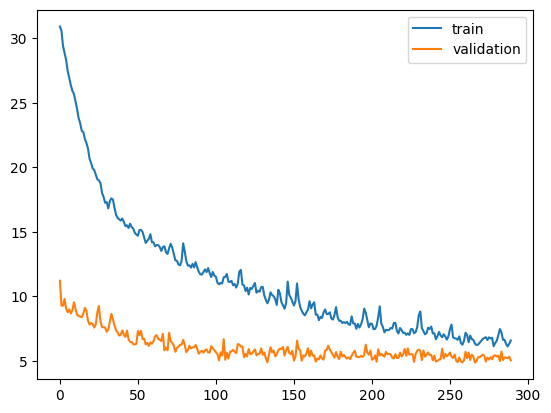

In [13]:
import matplotlib.pyplot as plt

start = 10
plt.plot(history.history['loss'][start:], label='train')
plt.plot(history.history['val_loss'][start:], label='validation')

plt.legend()
plt.show()

In [14]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape
    }

In [15]:
y_pred_train = model.predict(x_train_windows)
y_pred_test = model.predict(x_test_windows)

print(evaluate_model(y_train_windows, y_pred_train))
print(evaluate_model(y_test_windows, y_pred_test))

60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
{'mse': 148.14679555824844, 'r2': 0.9571362754863441, 'mae': 4.529615289819297, 'mape': 25830135242353.26}
{'mse': 5.789405612420224, 'r2': 0.9781141124309719, 'mae': 1.5864661742746828, 'mape': 0.11303511185431496}


In [16]:
x_test_windows.shape

(240, 10, 164)

In [17]:
baseline_predictions = []

for x in x_test_windows:
    baseline_predictions.append(x[-1][-1])

baseline_predictions = np.array(baseline_predictions).reshape(-1, 1)
print(evaluate_model(y_test_windows, baseline_predictions))

{'mse': 257.8424166666667, 'r2': 0.025269514786318892, 'mae': 10.981666666666666, 'mape': 1.2531154751810272}


In [18]:
# model.save('../models/lstm_model.keras')

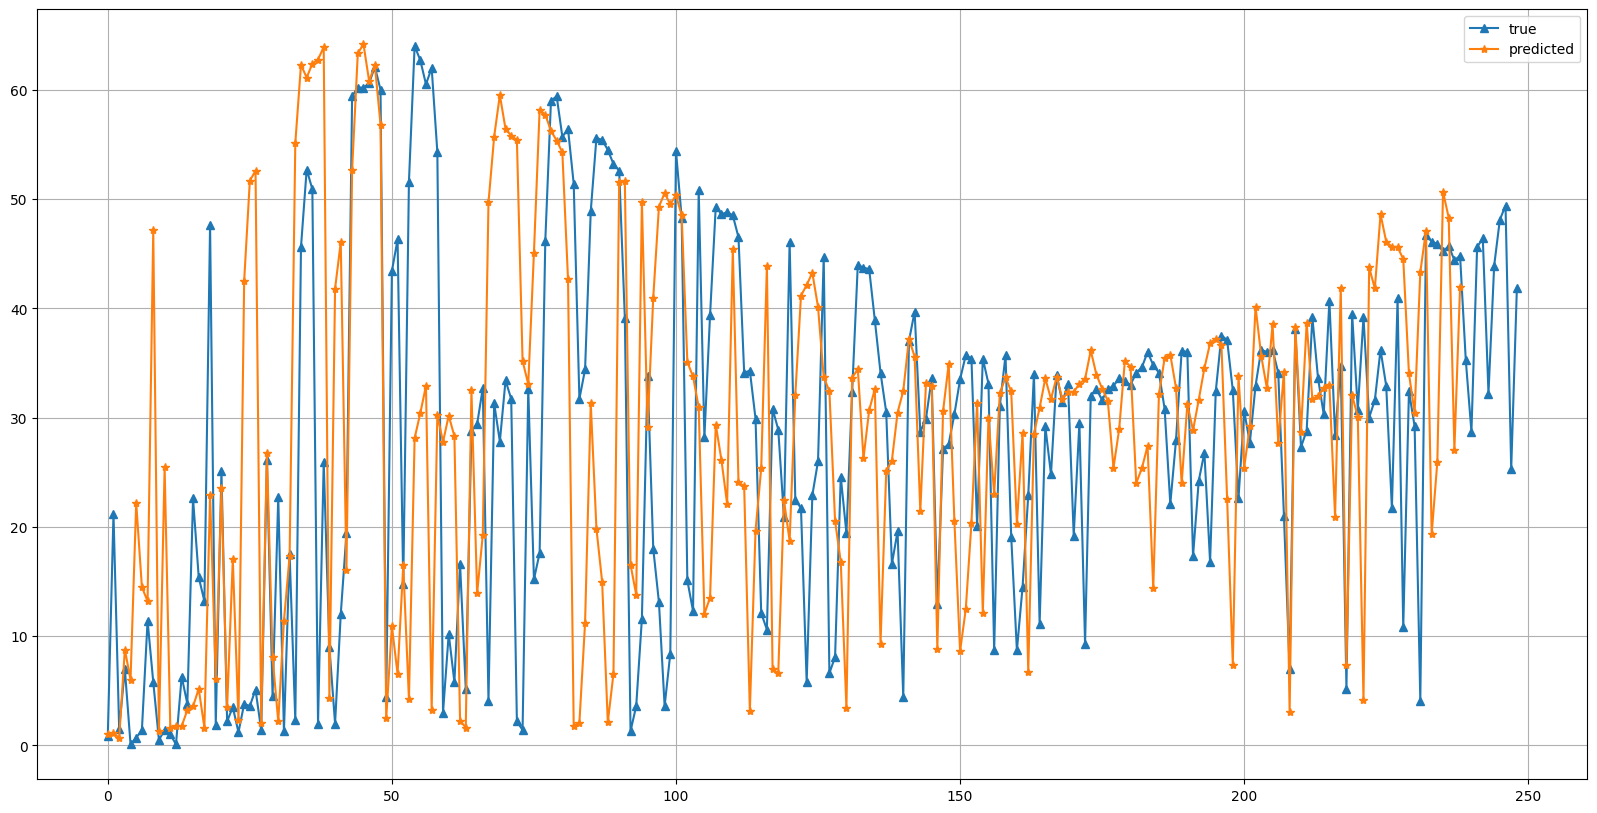

In [19]:
plt.figure(figsize=(20, 10))

start = 0
end = -1

plt.plot(y_test[start:end], '-^', label='true')
plt.plot(y_pred_test[start:end], '-*', label='predicted')

plt.legend()
plt.grid(True)
plt.show()

In [20]:
#Hyperparameter optimisation

import numpy as np
import random

# Exemple de fonction d'évaluation
# Cette fonction doit être remplacée par le processus d'évaluation de votre modèle
def evaluate_score(hyperparameters):
    # Ici, vous évaluerez votre modèle en utilisant les hyperparamètres
    # et retournerez une métrique de performance, comme l'accuracy
    # Pour cet exemple, on retourne une valeur aléatoire (à remplacer)
    model = Sequential([
        LSTM(hyperparameters[0], activation=hyperparameters[1], input_shape=(
            x_train_windows.shape[1:]), return_sequences=True),
        Dropout(hyperparameters[2]),
        LSTM(hyperparameters[3], activation=hyperparameters[4], return_sequences=False),
        Dropout(hyperparameters[5]),
        Dense(hyperparameters[6], activation=hyperparameters[7]),

        Dense(1, activation='linear')
    ])

    optimizer = Adam(learning_rate=hyperparameters[8])
    model.compile(optimizer=optimizer, loss='mean_absolute_error')

    model.fit(x=x_train_windows,
              y=y_train_windows,
              epochs=hyperparameters[9],
              batch_size=hyperparameters[10],
              validation_split=0.2,
              shuffle=False)

    y_pred_test = model.predict(x_test_windows)

    print("y_true shape:", y_test_windows.shape)
    print("y_pred shape:", y_pred_test.shape)

    evaluation = evaluate_model(y_test_windows, y_pred_test)

    return evaluation['mse']

# Fonction pour convertir la représentation numérique en chaîne de caractères pour l'hyperparamètre catégoriel
def correct_hyperparameters_value(hyperparameters_value):
    corrected_hyperparameters_value = hyperparameters_value.copy()
    categories = ['tanh', 'relu', 'sigmoid', 'hard_sigmoid', 'linear']

    corrected_hyperparameters_value[0] = int(np.round(hyperparameters_value[0]))
    corrected_hyperparameters_value[1] = categories[int(hyperparameters_value[1])]
    corrected_hyperparameters_value[3] = int(np.round(hyperparameters_value[3]))
    corrected_hyperparameters_value[4] = categories[int(hyperparameters_value[4])]
    corrected_hyperparameters_value[6] = int(np.round(hyperparameters_value[6]))
    corrected_hyperparameters_value[7] = categories[int(hyperparameters_value[7])]
    corrected_hyperparameters_value[9] = int(np.round(hyperparameters_value[9]))
    corrected_hyperparameters_value[10] = int(np.round(hyperparameters_value[10]))
    print(corrected_hyperparameters_value)

    return corrected_hyperparameters_value

# PSO
class Particle:
    def __init__(self, bounds):
        self.position = np.array([random.uniform(bound[0], bound[1]) for bound in bounds])
        self.velocity = np.array([random.uniform(-1, 1) for _ in bounds])
        self.best_position = self.position.copy()
        self.best_score = -float('inf')

    def update_velocity(self, global_best_position):
        w = 0.5  # inertie
        c1 = 0.8  # cognition (particule)
        c2 = 0.9  # social (essaim)
        
        for i in range(len(self.velocity)):
            r1, r2 = random.random(), random.random()
            cognitive_velocity = c1 * r1 * (self.best_position[i] - self.position[i])
            social_velocity = c2 * r2 * (global_best_position[i] - self.position[i])
            self.velocity[i] = w * self.velocity[i] + cognitive_velocity + social_velocity

    def update_position(self, bounds):
        self.position += self.velocity
        # Appliquer les contraintes de l'espace de recherche
        for i in range(len(self.position)):
            if self.position[i] < bounds[i][0]:
                self.position[i] = bounds[i][0]
            elif self.position[i] > bounds[i][1]:
                self.position[i] = bounds[i][1]

def pso(num_particles, bounds, num_iterations):
    particles = [Particle(bounds) for _ in range(num_particles)]
    global_best_score = float('inf')
    global_best_position = None

    for _ in range(num_iterations):
        particles_count = 1
        for particle in particles:
            hyperparameters = correct_hyperparameters_value(particle.position.copy().tolist()) # Coorection des valeurs des hyperparamètres

            score = evaluate_score(hyperparameters)
            print("iteration : ", _, " / particle_count : ", particles_count)
            print("hyperparameters : ", hyperparameters)
            print("mse : ", score)

            if score < particle.best_score:
                particle.best_score = score
                particle.best_position = particle.position.copy()

            if score < global_best_score:
                global_best_score = score
                global_best_position = particle.position.copy()
            
            particles_count += 1

        for particle in particles:
            particle.update_velocity(global_best_position)
            particle.update_position(bounds)
    
    return global_best_position, global_best_score

# Bounds de chaque hyperparamètre
bounds = [(16, 256),     # units LSTM 1
          (0, 4),        # activation LSTM 1
          (0, 0.9),        # rate dropout1
          (16, 256),     # units LSTM 2
          (0, 4),        # activation LSTM 2
          (0, 0.9),        # rate dropout 2
          (16, 256),     # units DENSE 1
          (0, 4),        # activation DENSE 1
          (0.0001, 0.001),    # learning rate OPTIMIZER
          (200, 400),    # epoch number
          (32, 128)]     # batch size

num_particles = 5
num_iterations = 10

best_position, best_score = pso(num_particles, bounds, num_iterations)
converted_best_position = correct_hyperparameters_value(best_position.copy().tolist())
print(f"Meilleure position: {converted_best_position}, Meilleur score: {best_score}")

[246, 'hard_sigmoid', 0.2957217005012834, 241, 'tanh', 0.06825481977968705, 120, 'sigmoid', 0.0008058462307674667, 376, 62]
Epoch 1/376


c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 30.4326 - val_loss: 18.8162
Epoch 2/376
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 27.0652 - val_loss: 18.0462
Epoch 3/376
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 26.5228 - val_loss: 17.4698
Epoch 4/376
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 26.0953 - val_loss: 16.9928
Epoch 5/376
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 25.7199 - val_loss: 16.5568
Epoch 6/376
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 25.3729 - val_loss: 16.1482
Epoch 7/376
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 25.0391 - val_loss: 15.7740
Epoch 8/376
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 24.7407 - val_loss: 15.4388
Epoch 9/376
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 24.4725 - val_loss: 15.1365
Epoch 10/376
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 24.2241 - val_loss: 14.8583
Epoch 11/376
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 23.9864 - val_loss: 14.6072
Epoch 12/376
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 31.4325 - val_loss: 18.8328
Epoch 2/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.0434 - val_loss: 17.7948
Epoch 3/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.4375 - val_loss: 17.5697
Epoch 4/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.2326 - val_loss: 17.3453
Epoch 5/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.0653 - val_loss: 17.1821
Epoch 6/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.9246 - val_loss: 17.0273
Epoch 7/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.8000 - val_loss: 16.8766
Epoch 8/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.6692 - val_loss: 16.7248
Epoch 9/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.5529 - val_loss: 16.5725
Epoch 10/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.3993 - val_loss: 16.4177
Epoch 11/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.1819 - val_loss: 16.2955
Epoch 12/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 28.4884 - val_loss: 11.8092
Epoch 2/333
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 20.7495 - val_loss: 12.3067
Epoch 3/333
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 21.3535 - val_loss: 14.6100
Epoch 4/333
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 21.0726 - val_loss: 14.2663
Epoch 5/333
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 21.7728 - val_loss: 15.2992
Epoch 6/333
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 20.1577 - val_loss: 20.2878
Epoch 7/333
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 20.8473 - val_loss: 17.9257
Epoch 8/333
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 23.4200 - val_loss: 12.1407
Epoch 9/333
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 22.6741 - val_loss: 14.3919
Epoch 10/333
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 19.7310 - val_loss: 10.4568
Epoch 11/333
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 16.3640 - val_loss: 10.7386
Epoch 12/333
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 32.1332 - val_loss: 20.9800
Epoch 2/379
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 28.4345 - val_loss: 19.2196
Epoch 3/379
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 27.3711 - val_loss: 18.6314
Epoch 4/379
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 26.8673 - val_loss: 17.9974
Epoch 5/379
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 26.4948 - val_loss: 17.6752
Epoch 6/379
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 26.1981 - val_loss: 17.3788
Epoch 7/379
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 25.9612 - val_loss: 17.1034
Epoch 8/379
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 25.7452 - val_loss: 16.8432
Epoch 9/379
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 25.5374 - val_loss: 16.5961
Epoch 10/379
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 25.3392 - val_loss: 16.3648
Epoch 11/379
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 25.1525 - val_loss: 16.1393
Epoch 12/379
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 33.4529 - val_loss: 22.8482
Epoch 2/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 31.4801 - val_loss: 21.0006
Epoch 3/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 30.2019 - val_loss: 19.7263
Epoch 4/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 29.2521 - val_loss: 18.8139
Epoch 5/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 28.5069 - val_loss: 18.1731
Epoch 6/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 27.9753 - val_loss: 17.6773
Epoch 7/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 27.5810 - val_loss: 17.2926
Epoch 8/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 27.2654 - val_loss: 16.9750
Epoch 9/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 27.0002 - val_loss: 16.6890
Epoch 10/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 26.7310 - val_loss: 16.4310
Epoch 11/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 26.5201 - val_loss: 16.1903
Epoch 12/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 32.2555 - val_loss: 23.4405
Epoch 2/375
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 31.0600 - val_loss: 21.0619
Epoch 3/375
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.1611 - val_loss: 19.6335
Epoch 4/375
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.2995 - val_loss: 19.2392
Epoch 5/375
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.9948 - val_loss: 19.0087
Epoch 6/375
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.8624 - val_loss: 18.9201
Epoch 7/375
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.7909 - val_loss: 18.8352
Epoch 8/375
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.7240 - val_loss: 18.7523
Epoch 9/375
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.6591 - val_loss: 18.6713
Epoch 10/375
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.5960 - val_loss: 18.5934
Epoch 11/375
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 27.5346 - val_loss: 18.5176
Epoch 12/375
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 32.1436 - val_loss: 19.5076
Epoch 2/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 27.9515 - val_loss: 18.4672
Epoch 3/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 27.3562 - val_loss: 17.9667
Epoch 4/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26.9726 - val_loss: 17.5224
Epoch 5/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 26.6350 - val_loss: 17.1344
Epoch 6/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26.3280 - val_loss: 16.7787
Epoch 7/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26.0421 - val_loss: 16.4481
Epoch 8/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 25.7752 - val_loss: 16.1365
Epoch 9/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 25.5174 - val_loss: 15.8418
Epoch 10/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.2790 - val_loss: 15.5723
Epoch 11/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 25.0586 - val_loss: 15.3195
Epoch 12/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 31.2948 - val_loss: 18.8626
Epoch 2/356
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 27.9203 - val_loss: 18.0742
Epoch 3/356
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 27.2534 - val_loss: 17.4491
Epoch 4/356
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 26.7921 - val_loss: 16.9421
Epoch 5/356
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 26.3573 - val_loss: 16.4869
Epoch 6/356
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.9892 - val_loss: 16.0562
Epoch 7/356
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 25.6401 - val_loss: 15.6699
Epoch 8/356
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.3241 - val_loss: 15.3023
Epoch 9/356
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.0450 - val_loss: 14.9850
Epoch 10/356
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 24.7681 - val_loss: 14.7020
Epoch 11/356
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 24.5317 - val_loss: 14.5118
Epoch 12/356
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 32.7955 - val_loss: 24.6249
Epoch 2/379
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 32.4346 - val_loss: 24.2281
Epoch 3/379
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 32.0682 - val_loss: 23.7902
Epoch 4/379
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 31.6880 - val_loss: 23.3131
Epoch 5/379
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 31.3015 - val_loss: 22.8311
Epoch 6/379
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 30.9069 - val_loss: 22.3856
Epoch 7/379
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 30.5625 - val_loss: 21.9753
Epoch 8/379
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 30.2165 - val_loss: 21.5997
Epoch 9/379
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 29.9408 - val_loss: 21.2571
Epoch 10/379
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 29.6969 - val_loss: 20.9434
Epoch 11/379
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 29.4335 - val_loss: 20.6574
Epoch 12/379
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 33.4153 - val_loss: 21.6788
Epoch 2/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 31.0613 - val_loss: 19.4095
Epoch 3/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 29.5645 - val_loss: 18.0417
Epoch 4/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 28.3928 - val_loss: 17.1743
Epoch 5/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 27.7242 - val_loss: 16.6156
Epoch 6/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 27.1136 - val_loss: 16.1623
Epoch 7/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 26.6756 - val_loss: 15.7751
Epoch 8/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 26.3005 - val_loss: 15.4254
Epoch 9/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 25.9223 - val_loss: 15.1256
Epoch 10/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 25.5636 - val_loss: 14.8610
Epoch 11/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 25.3264 - val_loss: 14.6299
Epoch 12/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 33.4751 - val_loss: 24.5063
Epoch 2/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32.9365 - val_loss: 23.6782
Epoch 3/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32.2136 - val_loss: 22.7656
Epoch 4/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 31.5639 - val_loss: 21.9830
Epoch 5/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 31.0205 - val_loss: 21.3095
Epoch 6/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 30.5748 - val_loss: 20.6067
Epoch 7/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 30.1483 - val_loss: 20.2653
Epoch 8/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.8242 - val_loss: 19.7978
Epoch 9/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 29.5369 - val_loss: 19.5480
Epoch 10/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 29.2578 - val_loss: 19.3910
Epoch 11/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.0350 - val_loss: 19.2137
Epoch 12/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 31.6406 - val_loss: 19.3910
Epoch 2/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 28.3639 - val_loss: 18.3169
Epoch 3/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 27.6560 - val_loss: 17.6987
Epoch 4/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 27.2049 - val_loss: 17.2123
Epoch 5/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26.8270 - val_loss: 16.7908
Epoch 6/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26.4880 - val_loss: 16.4078
Epoch 7/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26.1772 - val_loss: 16.0506
Epoch 8/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 25.8821 - val_loss: 15.7215
Epoch 9/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 25.6139 - val_loss: 15.4135
Epoch 10/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 25.3625 - val_loss: 15.1290
Epoch 11/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 25.1232 - val_loss: 14.8676
Epoch 12/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 32.3744 - val_loss: 19.1876
Epoch 2/363
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.7170 - val_loss: 18.5683
Epoch 3/363
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.0156 - val_loss: 18.0164
Epoch 4/363
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 27.5156 - val_loss: 17.5443
Epoch 5/363
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 27.1269 - val_loss: 17.1343
Epoch 6/363
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.8198 - val_loss: 16.7743
Epoch 7/363
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.5055 - val_loss: 16.4228
Epoch 8/363
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.2025 - val_loss: 16.0811
Epoch 9/363
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.9199 - val_loss: 15.7704
Epoch 10/363
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.6617 - val_loss: 15.4842
Epoch 11/363
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.4151 - val_loss: 15.2231
Epoch 12/363
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 33.2214 - val_loss: 24.7713
Epoch 2/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 32.8534 - val_loss: 24.3684
Epoch 3/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 32.4949 - val_loss: 23.9213
Epoch 4/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 32.0884 - val_loss: 23.4309
Epoch 5/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 31.6904 - val_loss: 22.9352
Epoch 6/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 31.2996 - val_loss: 22.4766
Epoch 7/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 30.9718 - val_loss: 22.0590
Epoch 8/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 30.6523 - val_loss: 21.6821
Epoch 9/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 30.3697 - val_loss: 21.3426
Epoch 10/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 30.0958 - val_loss: 21.0338
Epoch 11/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 29.8607 - val_loss: 20.7503
Epoch 12/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 32.8294 - val_loss: 21.4710
Epoch 2/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 30.7152 - val_loss: 19.3685
Epoch 3/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 29.3902 - val_loss: 17.9004
Epoch 4/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 28.2858 - val_loss: 16.9255
Epoch 5/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 27.5212 - val_loss: 16.2960
Epoch 6/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 26.8683 - val_loss: 15.8241
Epoch 7/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 26.3888 - val_loss: 15.4255
Epoch 8/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 26.0813 - val_loss: 15.0818
Epoch 9/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 25.6576 - val_loss: 14.7749
Epoch 10/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 25.2982 - val_loss: 14.5063
Epoch 11/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 25.0443 - val_loss: 14.2649
Epoch 12/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 33.2799 - val_loss: 24.2819
Epoch 2/376
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 32.3342 - val_loss: 23.5688
Epoch 3/376
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 31.6819 - val_loss: 22.4726
Epoch 4/376
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 30.9441 - val_loss: 21.6081
Epoch 5/376
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 30.4012 - val_loss: 20.8286
Epoch 6/376
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 30.0055 - val_loss: 20.2099
Epoch 7/376
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.6202 - val_loss: 19.9017
Epoch 8/376
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 29.3241 - val_loss: 19.7808
Epoch 9/376
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.1371 - val_loss: 19.5987
Epoch 10/376
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28.9465 - val_loss: 19.4587
Epoch 11/376
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28.8040 - val_loss: 19.3222
Epoch 12/376
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 31.6671 - val_loss: 19.2775
Epoch 2/381
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28.3515 - val_loss: 17.8767
Epoch 3/381
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.4792 - val_loss: 17.2344
Epoch 4/381
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.0057 - val_loss: 16.7460
Epoch 5/381
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 26.6183 - val_loss: 16.3190
Epoch 6/381
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 26.2697 - val_loss: 15.9170
Epoch 7/381
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 25.9420 - val_loss: 15.5607
Epoch 8/381
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 25.6524 - val_loss: 15.2427
Epoch 9/381
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 25.3930 - val_loss: 14.9627
Epoch 10/381
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 25.1544 - val_loss: 14.7099
Epoch 11/381
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 24.9317 - val_loss: 14.4858
Epoch 12/381
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 31.6454 - val_loss: 19.4381
Epoch 2/373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.2565 - val_loss: 17.8887
Epoch 3/373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.1659 - val_loss: 17.2134
Epoch 4/373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.6320 - val_loss: 16.7264
Epoch 5/373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.2193 - val_loss: 16.2971
Epoch 6/373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 25.8662 - val_loss: 15.8990
Epoch 7/373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 25.5373 - val_loss: 15.5417
Epoch 8/373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.2401 - val_loss: 15.2175
Epoch 9/373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 24.9672 - val_loss: 14.9240
Epoch 10/373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 24.7121 - val_loss: 14.6526
Epoch 11/373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 24.4688 - val_loss: 14.4111
Epoch 12/373
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 32.1686 - val_loss: 23.0219
Epoch 2/377
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 31.4334 - val_loss: 21.9378
Epoch 3/377
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 30.8727 - val_loss: 20.9108
Epoch 4/377
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 30.3579 - val_loss: 20.2291
Epoch 5/377
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.9739 - val_loss: 19.6480
Epoch 6/377
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 29.6792 - val_loss: 19.3744
Epoch 7/377
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 29.4037 - val_loss: 19.1039
Epoch 8/377
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.2344 - val_loss: 18.9998
Epoch 9/377
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 29.0688 - val_loss: 18.6709
Epoch 10/377
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 28.8441 - val_loss: 18.4557
Epoch 11/377
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 28.7449 - val_loss: 18.2759
Epoch 12/377
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 32.7185 - val_loss: 21.1684
Epoch 2/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 29.9693 - val_loss: 18.9718
Epoch 3/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 28.4431 - val_loss: 17.7224
Epoch 4/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 27.5442 - val_loss: 17.0104
Epoch 5/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 26.9641 - val_loss: 16.5137
Epoch 6/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 26.5612 - val_loss: 16.1068
Epoch 7/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 26.2158 - val_loss: 15.7486
Epoch 8/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 25.9030 - val_loss: 15.4252
Epoch 9/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 25.6253 - val_loss: 15.1308
Epoch 10/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 25.3641 - val_loss: 14.8639
Epoch 11/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 25.1270 - val_loss: 14.6277
Epoch 12/376
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 32.4286 - val_loss: 23.1768
Epoch 2/378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 30.9649 - val_loss: 20.9679
Epoch 3/378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.4039 - val_loss: 19.6666
Epoch 4/378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28.6599 - val_loss: 19.2708
Epoch 5/378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.3310 - val_loss: 19.0446
Epoch 6/378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.1251 - val_loss: 18.9415
Epoch 7/378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.9977 - val_loss: 18.8471
Epoch 8/378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.9024 - val_loss: 18.7597
Epoch 9/378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.8041 - val_loss: 18.5960
Epoch 10/378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.6694 - val_loss: 18.4863
Epoch 11/378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.5837 - val_loss: 18.4068
Epoch 12/378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 32.3772 - val_loss: 20.0360
Epoch 2/384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28.1722 - val_loss: 17.9162
Epoch 3/384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.9721 - val_loss: 17.2817
Epoch 4/384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.4945 - val_loss: 16.7433
Epoch 5/384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.0640 - val_loss: 16.2528
Epoch 6/384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.6638 - val_loss: 15.7989
Epoch 7/384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.2992 - val_loss: 15.4018
Epoch 8/384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 24.9795 - val_loss: 15.0508
Epoch 9/384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 24.6865 - val_loss: 14.7365
Epoch 10/384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 24.4153 - val_loss: 14.4635
Epoch 11/384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 24.1637 - val_loss: 14.2194
Epoch 12/384
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 30.7990 - val_loss: 18.0292
Epoch 2/361
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 27.2355 - val_loss: 16.8843
Epoch 3/361
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 26.4527 - val_loss: 16.3122
Epoch 4/361
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.9857 - val_loss: 15.8286
Epoch 5/361
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 25.5941 - val_loss: 15.4178
Epoch 6/361
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 25.2579 - val_loss: 15.0645
Epoch 7/361
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 24.9601 - val_loss: 14.7566
Epoch 8/361
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 24.6919 - val_loss: 14.4867
Epoch 9/361
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 24.3227 - val_loss: 14.1462
Epoch 10/361
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 23.6874 - val_loss: 13.5553
Epoch 11/361
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 23.1780 - val_loss: 13.3092
Epoch 12/361
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 33.1183 - val_loss: 24.1633
Epoch 2/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32.2347 - val_loss: 22.5413
Epoch 3/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 30.4079 - val_loss: 19.8151
Epoch 4/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28.5707 - val_loss: 19.0254
Epoch 5/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.1058 - val_loss: 18.8621
Epoch 6/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.0146 - val_loss: 18.7863
Epoch 7/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.9536 - val_loss: 18.7080
Epoch 8/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.8940 - val_loss: 18.6394
Epoch 9/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.8401 - val_loss: 18.5735
Epoch 10/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.7875 - val_loss: 18.5087
Epoch 11/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.7357 - val_loss: 18.4449
Epoch 12/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 33.2758 - val_loss: 21.1865
Epoch 2/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 29.8348 - val_loss: 19.3934
Epoch 3/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28.6267 - val_loss: 18.4910
Epoch 4/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 27.9791 - val_loss: 17.8667
Epoch 5/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 27.5171 - val_loss: 17.3886
Epoch 6/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 27.1550 - val_loss: 16.9800
Epoch 7/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.8251 - val_loss: 16.6030
Epoch 8/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 26.5228 - val_loss: 16.2530
Epoch 9/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 26.2298 - val_loss: 15.9123
Epoch 10/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 25.9535 - val_loss: 15.6067
Epoch 11/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 25.7007 - val_loss: 15.3291
Epoch 12/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 33.3248 - val_loss: 23.6788
Epoch 2/378
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 31.5237 - val_loss: 21.7845
Epoch 3/378
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 30.0432 - val_loss: 20.6194
Epoch 4/378
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 29.2249 - val_loss: 19.9872
Epoch 5/378
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 28.7818 - val_loss: 19.6267
Epoch 6/378
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 28.5198 - val_loss: 19.3887
Epoch 7/378
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 28.3379 - val_loss: 19.2073
Epoch 8/378
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 28.1982 - val_loss: 19.0583
Epoch 9/378
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 28.0806 - val_loss: 18.9273
Epoch 10/378
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 27.9781 - val_loss: 18.8074
Epoch 11/378
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 27.8843 - val_loss: 18.6950
Epoch 12/378
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 31.1467 - val_loss: 18.8377
Epoch 2/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 28.2462 - val_loss: 18.0150
Epoch 3/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 27.6824 - val_loss: 17.4896
Epoch 4/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 27.2875 - val_loss: 17.0492
Epoch 5/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 26.9335 - val_loss: 16.6494
Epoch 6/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 26.6150 - val_loss: 16.2862
Epoch 7/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 26.3197 - val_loss: 15.9450
Epoch 8/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 26.0786 - val_loss: 15.7221
Epoch 9/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 25.8635 - val_loss: 15.4348
Epoch 10/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 25.6255 - val_loss: 15.1722
Epoch 11/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 25.3661 - val_loss: 14.9099
Epoch 12/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 29.0825 - val_loss: 12.9725
Epoch 2/365
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 21.7639 - val_loss: 11.4374
Epoch 3/365
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 20.4698 - val_loss: 9.8349
Epoch 4/365
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 18.4706 - val_loss: 9.5195
Epoch 5/365
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 17.1615 - val_loss: 9.1406
Epoch 6/365
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 16.5321 - val_loss: 8.9973
Epoch 7/365
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 15.5408 - val_loss: 9.7592
Epoch 8/365
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 15.2882 - val_loss: 8.8121
Epoch 9/365
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 14.0255 - val_loss: 8.8500
Epoch 10/365
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 13.5355 - val_loss: 8.5324
Epoch 11/365
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 13.1134 - val_loss: 8.7221
Epoch 12/365
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/ste

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 33.5216 - val_loss: 24.4115
Epoch 2/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 32.7711 - val_loss: 23.5972
Epoch 3/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 31.9924 - val_loss: 22.7015
Epoch 4/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 31.2063 - val_loss: 21.8403
Epoch 5/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 30.5147 - val_loss: 21.1394
Epoch 6/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 29.9771 - val_loss: 20.5980
Epoch 7/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 29.5638 - val_loss: 20.1801
Epoch 8/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 29.2411 - val_loss: 19.8486
Epoch 9/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 28.9823 - val_loss: 19.5769
Epoch 10/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 28.7666 - val_loss: 19.3484
Epoch 11/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 28.5842 - val_loss: 19.1511
Epoch 12/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 32.8417 - val_loss: 20.3422
Epoch 2/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 29.2045 - val_loss: 18.7728
Epoch 3/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.1639 - val_loss: 18.0081
Epoch 4/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.6173 - val_loss: 17.4800
Epoch 5/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.2240 - val_loss: 17.0676
Epoch 6/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.8956 - val_loss: 16.6874
Epoch 7/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.5909 - val_loss: 16.3285
Epoch 8/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.2936 - val_loss: 15.9844
Epoch 9/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.0100 - val_loss: 15.6740
Epoch 10/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 25.7562 - val_loss: 15.3906
Epoch 11/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.5278 - val_loss: 15.1374
Epoch 12/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 33.6859 - val_loss: 24.2918
Epoch 2/378
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 32.3782 - val_loss: 21.2839
Epoch 3/378
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 29.6442 - val_loss: 19.6826
Epoch 4/378
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 28.9173 - val_loss: 19.5231
Epoch 5/378
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 28.7528 - val_loss: 19.3729
Epoch 6/378
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 28.6740 - val_loss: 19.2963
Epoch 7/378
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 28.6121 - val_loss: 19.2235
Epoch 8/378
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 28.5532 - val_loss: 19.1526
Epoch 9/378
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 28.4953 - val_loss: 19.0825
Epoch 10/378
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 28.4388 - val_loss: 19.0140
Epoch 11/378
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 28.3834 - val_loss: 18.9475
Epoch 12/378
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 31.2753 - val_loss: 18.8905
Epoch 2/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 28.1522 - val_loss: 18.1757
Epoch 3/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 27.6491 - val_loss: 17.6014
Epoch 4/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 27.1929 - val_loss: 17.1070
Epoch 5/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 26.7920 - val_loss: 16.6583
Epoch 6/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 26.4766 - val_loss: 16.2903
Epoch 7/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 26.1462 - val_loss: 15.9132
Epoch 8/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.8758 - val_loss: 15.6336
Epoch 9/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 25.6131 - val_loss: 15.3223
Epoch 10/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.3782 - val_loss: 15.0757
Epoch 11/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 25.1532 - val_loss: 14.7713
Epoch 12/384
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 30.4965 - val_loss: 18.2858
Epoch 2/360
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 27.1840 - val_loss: 17.6295
Epoch 3/360
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 26.6914 - val_loss: 17.1046
Epoch 4/360
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 26.2819 - val_loss: 16.6433
Epoch 5/360
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 25.9137 - val_loss: 16.2248
Epoch 6/360
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 25.5722 - val_loss: 15.8349
Epoch 7/360
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 25.2664 - val_loss: 15.4843
Epoch 8/360
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 24.9733 - val_loss: 15.1661
Epoch 9/360
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 24.7122 - val_loss: 14.8834
Epoch 10/360
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 24.4718 - val_loss: 14.6287
Epoch 11/360
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 24.2419 - val_loss: 14.3975
Epoch 12/360
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 33.4728 - val_loss: 25.2735
Epoch 2/381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 33.0632 - val_loss: 24.8285
Epoch 3/381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32.6049 - val_loss: 24.2902
Epoch 4/381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 32.0632 - val_loss: 23.6806
Epoch 5/381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 31.4984 - val_loss: 23.0882
Epoch 6/381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 30.9843 - val_loss: 22.5516
Epoch 7/381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 30.5269 - val_loss: 22.0595
Epoch 8/381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 30.1206 - val_loss: 21.5968
Epoch 9/381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.7465 - val_loss: 21.1599
Epoch 10/381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.3944 - val_loss: 20.7477
Epoch 11/381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.0670 - val_loss: 20.3759
Epoch 12/381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 31.9593 - val_loss: 19.7348
Epoch 2/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.6888 - val_loss: 17.9454
Epoch 3/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 27.5179 - val_loss: 17.1295
Epoch 4/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.9248 - val_loss: 16.5881
Epoch 5/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 26.4943 - val_loss: 16.1226
Epoch 6/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.1103 - val_loss: 15.7027
Epoch 7/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.7691 - val_loss: 15.3280
Epoch 8/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.4649 - val_loss: 15.0053
Epoch 9/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 25.1910 - val_loss: 14.7216
Epoch 10/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 24.9439 - val_loss: 14.4737
Epoch 11/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 24.7115 - val_loss: 14.2519
Epoch 12/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 32.8306 - val_loss: 23.8922
Epoch 2/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 31.9134 - val_loss: 21.6784
Epoch 3/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 29.6945 - val_loss: 19.4700
Epoch 4/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 28.4078 - val_loss: 19.1582
Epoch 5/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 28.2024 - val_loss: 18.9542
Epoch 6/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 28.0903 - val_loss: 18.8814
Epoch 7/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 28.0279 - val_loss: 18.7980
Epoch 8/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 27.9654 - val_loss: 18.7269
Epoch 9/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 27.9091 - val_loss: 18.6578
Epoch 10/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 27.8549 - val_loss: 18.5913
Epoch 11/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 27.8017 - val_loss: 18.5259
Epoch 12/377
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 30.5327 - val_loss: 17.6983
Epoch 2/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 27.4466 - val_loss: 17.2454
Epoch 3/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 27.0959 - val_loss: 16.8873
Epoch 4/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 26.7885 - val_loss: 16.5010
Epoch 5/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 26.4973 - val_loss: 16.1702
Epoch 6/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 26.2245 - val_loss: 15.8584
Epoch 7/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.9726 - val_loss: 15.5769
Epoch 8/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.7431 - val_loss: 15.3156
Epoch 9/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 25.5306 - val_loss: 15.0777
Epoch 10/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.3319 - val_loss: 14.8594
Epoch 11/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 25.1449 - val_loss: 14.6621
Epoch 12/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 31.7946 - val_loss: 18.9484
Epoch 2/349
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 28.4316 - val_loss: 18.2654
Epoch 3/349
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 27.8457 - val_loss: 17.6245
Epoch 4/349
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 27.4085 - val_loss: 17.1889
Epoch 5/349
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 27.0554 - val_loss: 16.7977
Epoch 6/349
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 26.7442 - val_loss: 16.4405
Epoch 7/349
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 26.4562 - val_loss: 16.1064
Epoch 8/349
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 26.1813 - val_loss: 15.7961
Epoch 9/349
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 25.9295 - val_loss: 15.5147
Epoch 10/349
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 25.6966 - val_loss: 15.2556
Epoch 11/349
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 25.4868 - val_loss: 15.0230
Epoch 12/349
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 32.0439 - val_loss: 23.5534
Epoch 2/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 31.7590 - val_loss: 23.2185
Epoch 3/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 31.4568 - val_loss: 22.8332
Epoch 4/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 31.1121 - val_loss: 22.4019
Epoch 5/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 30.7427 - val_loss: 21.9616
Epoch 6/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 30.3842 - val_loss: 21.5431
Epoch 7/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 30.0488 - val_loss: 21.1539
Epoch 8/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 29.7335 - val_loss: 20.7812
Epoch 9/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 29.4332 - val_loss: 20.4191
Epoch 10/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 29.1433 - val_loss: 20.0830
Epoch 11/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 28.8684 - val_loss: 19.7675
Epoch 12/381
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 33.4727 - val_loss: 21.3622
Epoch 2/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 30.1057 - val_loss: 19.3033
Epoch 3/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 28.7046 - val_loss: 18.4023
Epoch 4/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 28.0095 - val_loss: 17.8208
Epoch 5/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 27.5497 - val_loss: 17.3847
Epoch 6/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 27.1915 - val_loss: 17.0136
Epoch 7/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.8924 - val_loss: 16.6704
Epoch 8/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.6095 - val_loss: 16.3496
Epoch 9/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.3390 - val_loss: 16.0288
Epoch 10/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.0667 - val_loss: 15.7189
Epoch 11/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 25.8120 - val_loss: 15.4332
Epoch 12/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 32.2317 - val_loss: 23.4525
Epoch 2/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 31.3812 - val_loss: 22.3142
Epoch 3/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 30.3812 - val_loss: 21.1274
Epoch 4/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 29.5223 - val_loss: 20.4546
Epoch 5/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 29.0068 - val_loss: 20.0230
Epoch 6/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 28.6621 - val_loss: 19.6872
Epoch 7/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 28.4010 - val_loss: 19.4149
Epoch 8/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 28.1840 - val_loss: 19.1837
Epoch 9/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 28.0043 - val_loss: 18.9913
Epoch 10/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 27.8501 - val_loss: 18.8264
Epoch 11/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 27.7237 - val_loss: 18.6777
Epoch 12/379
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 31.4871 - val_loss: 18.6865
Epoch 2/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 28.1819 - val_loss: 18.0594
Epoch 3/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 27.7136 - val_loss: 17.5659
Epoch 4/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 27.3471 - val_loss: 17.1589
Epoch 5/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 27.0276 - val_loss: 16.7958
Epoch 6/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 26.7364 - val_loss: 16.4605
Epoch 7/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 26.4668 - val_loss: 16.1456
Epoch 8/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 26.2068 - val_loss: 15.8485
Epoch 9/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 25.9669 - val_loss: 15.5799
Epoch 10/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 25.7472 - val_loss: 15.3293
Epoch 11/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.5446 - val_loss: 15.1004
Epoch 12/383
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 31.1957 - val_loss: 18.6125
Epoch 2/344
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 27.8787 - val_loss: 17.7669
Epoch 3/344
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 27.2018 - val_loss: 17.2000
Epoch 4/344
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 26.7769 - val_loss: 16.6949
Epoch 5/344
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 26.4172 - val_loss: 16.2335
Epoch 6/344
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 26.0230 - val_loss: 15.8109
Epoch 7/344
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 25.6391 - val_loss: 15.4333
Epoch 8/344
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 25.3351 - val_loss: 15.1016
Epoch 9/344
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.0570 - val_loss: 14.8007
Epoch 10/344
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 24.7609 - val_loss: 14.5402
Epoch 11/344
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 24.5161 - val_loss: 14.3047
Epoch 12/344
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 33.1184 - val_loss: 24.3922
Epoch 2/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 32.3711 - val_loss: 23.6313
Epoch 3/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 31.6130 - val_loss: 22.3617
Epoch 4/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 30.6316 - val_loss: 20.9190
Epoch 5/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.6736 - val_loss: 20.3150
Epoch 6/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.1605 - val_loss: 19.9392
Epoch 7/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 28.8773 - val_loss: 19.7373
Epoch 8/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28.6956 - val_loss: 19.6384
Epoch 9/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 28.5637 - val_loss: 19.4757
Epoch 10/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28.4157 - val_loss: 19.3824
Epoch 11/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 28.3224 - val_loss: 19.1878
Epoch 12/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 32.8292 - val_loss: 20.9442
Epoch 2/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 29.8007 - val_loss: 18.5326
Epoch 3/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 28.1948 - val_loss: 17.3186
Epoch 4/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 27.3033 - val_loss: 16.6693
Epoch 5/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26.7142 - val_loss: 16.1835
Epoch 6/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26.2777 - val_loss: 15.7595
Epoch 7/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 25.9058 - val_loss: 15.3902
Epoch 8/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 25.6037 - val_loss: 15.0774
Epoch 9/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 25.3383 - val_loss: 14.8007
Epoch 10/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 25.0690 - val_loss: 14.5580
Epoch 11/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 24.8486 - val_loss: 14.3387
Epoch 12/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 32.4263 - val_loss: 22.8547
Epoch 2/380
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 30.2997 - val_loss: 19.6466
Epoch 3/380
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 28.2395 - val_loss: 18.8425
Epoch 4/380
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 27.7122 - val_loss: 18.6187
Epoch 5/380
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 27.5592 - val_loss: 18.5222
Epoch 6/380
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 27.4586 - val_loss: 18.3696
Epoch 7/380
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 27.3516 - val_loss: 18.2790
Epoch 8/380
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 27.2713 - val_loss: 18.1971
Epoch 9/380
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 27.1969 - val_loss: 18.1183
Epoch 10/380
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 27.1214 - val_loss: 18.0363
Epoch 11/380
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 27.0295 - val_loss: 17.9611
Epoch 12/380
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 31.3464 - val_loss: 19.8036
Epoch 2/382
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 28.1485 - val_loss: 18.2596
Epoch 3/382
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 27.1337 - val_loss: 17.5252
Epoch 4/382
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 26.6093 - val_loss: 17.0047
Epoch 5/382
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 26.2038 - val_loss: 16.5561
Epoch 6/382
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 25.8477 - val_loss: 16.1542
Epoch 7/382
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 25.5189 - val_loss: 15.7863
Epoch 8/382
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 25.2211 - val_loss: 15.4531
Epoch 9/382
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 24.9516 - val_loss: 15.1470
Epoch 10/382
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 24.6970 - val_loss: 14.8682
Epoch 11/382
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 24.4585 - val_loss: 14.6151
Epoch 12/382
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 31.2726 - val_loss: 18.9574
Epoch 2/348
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 27.7540 - val_loss: 17.6782
Epoch 3/348
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 26.8821 - val_loss: 17.0037
Epoch 4/348
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 26.3594 - val_loss: 16.4556
Epoch 5/348
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.9198 - val_loss: 15.9668
Epoch 6/348
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.5188 - val_loss: 15.5240
Epoch 7/348
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 25.1597 - val_loss: 15.1406
Epoch 8/348
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 24.8437 - val_loss: 14.8041
Epoch 9/348
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 24.5533 - val_loss: 14.5001
Epoch 10/348
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 24.2707 - val_loss: 14.2289
Epoch 11/348
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 24.0135 - val_loss: 14.0027
Epoch 12/348
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 33.4000 - val_loss: 24.1527
Epoch 2/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 32.9109 - val_loss: 23.5986
Epoch 3/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 32.3767 - val_loss: 22.9242
Epoch 4/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 31.7627 - val_loss: 22.1553
Epoch 5/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 31.1093 - val_loss: 21.4085
Epoch 6/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 30.5225 - val_loss: 20.7692
Epoch 7/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 30.0282 - val_loss: 20.2364
Epoch 8/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 29.6060 - val_loss: 19.7842
Epoch 9/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 29.2440 - val_loss: 19.3930
Epoch 10/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 28.9217 - val_loss: 19.0325
Epoch 11/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 28.6542 - val_loss: 18.7228
Epoch 12/380
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

c:\Users\tomst\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 32.9596 - val_loss: 21.2607
Epoch 2/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 30.1924 - val_loss: 19.3269
Epoch 3/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 28.7755 - val_loss: 18.2465
Epoch 4/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 27.9159 - val_loss: 17.5078
Epoch 5/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 27.3226 - val_loss: 16.9767
Epoch 6/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26.8925 - val_loss: 16.5237
Epoch 7/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 26.5077 - val_loss: 16.1067
Epoch 8/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 26.1621 - val_loss: 15.7136
Epoch 9/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 25.8276 - val_loss: 15.3615
Epoch 10/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 25.5372 - val_loss: 15.0556
Epoch 11/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 25.2688 - val_loss: 14.7836
Epoch 12/378
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s